In [343]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

from keras.models import Sequential
from keras.layers import Dense

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%matplotlib inline

In [2]:
#Import global confirmed cases
data = pd.read_csv('COVIDGlobalConfirmed.txt')
data = pd.concat([data.iloc[:, 1:2], data.iloc[:, 4:]], axis = 1)
data = data.set_index('Country/Region')

#Calculate new cases from total cases
data2 = data.diff(axis = 1).iloc[:, 1:]

#Keep only regions with more than 500 total cases
data3 = data2[data2.sum(axis = 1) > 500]

#Remove cruise ship assuming not representative of normal spread
data3 = data3[data3.index != 'Diamond Princess']

#Reshape data for plotting
data4 = data3.T.reset_index()
data4['index'] = pd.to_datetime(data4['index'])

In [23]:
#Create template for cleaning data

#Pull first country's data
c1 = pd.concat([data4['index'], data4.iloc[:, 1:2]], axis = 1)

#Add number to country name in case there are duplicates
c1['country'] = c1.columns[1] + str(0)

#Rename columns
c1.columns = ['date', 'new', 'country']

#Drop leading zeros up until first case
c1 = c1[c1['date'] >= c1[c1['new'] > 0]['date'].min()]

#Calculate the total previous to data point
c1['prevTtl'] = c1['new'].cumsum() - c1['new']

#Append new cases from day before
c1['prevNew'] = c1.new.shift(1)

#Calculate days from peak
c1['rel2Peak'] = c1['date'] - c1[c1['new'] == c1['new'].max()]['date'].min()
r2p = []
for i in range(len(c1['rel2Peak'])):
    r = c1['rel2Peak'].iloc[i].days
    r2p.append(r)
c1['rel2Peak'] = r2p
c1['peak'] = c1[c1['new'] == c1['new'].max()]['new'].values[0]

#Calculate peak prior to data point date
prevPeak = []
for i in range(len(c1)):
    pP = c1[c1['date'] < c1.iloc[i:i+1, :]['date'][c1.iloc[i:i+1, :]['date'].index[0]]]['new'].max()    
    prevPeak.append(pP)
c1['prevPeak'] = prevPeak

#Reset and drop index
c1 = c1.reset_index(drop=True)

#Calculate days from prevPeak
r2P = [0]
for j in range(len(c1) - 1):
    d = c1[c1['new'] == c1.iloc[j+1:j+2, :]['prevPeak'][j+1]]['date'].min()
    d2 = c1.iloc[j+1:j+2, :]['date'] - d
    r2P.append(d2[j+1].days)
c1['R2P'] = r2P

#Rolling average new cases
c1['avgNew3'] = c1.new.rolling(3).mean()

#Rolling sum new cases
c1['sumNew3'] = c1.new.rolling(3).sum()

#Rolling avg change in new
c1['avgChng3'] = c1['new'].diff().rolling(3).mean()

#Rolling average sum change in new
c1['sumChng3'] = c1['new'].diff().rolling(3).sum()

#Replace NaN values with zeros
c1 = c1.fillna(0)

#Clean and reshape data for plotting
forPlot = c1

for i in range(data4.shape[1] - 3):
    c = pd.concat([data4['index'], data4.iloc[:, i+2:i+3]], axis = 1)
    c['country'] = c.columns[1] + str(i+1)
    c.columns = ['date', 'new', 'country']
    c = c[c['date'] >= c[c['new'] > 0]['date'].min()]
    c['prevTtl'] = c['new'].cumsum() - c['new']
    c['prevNew'] = c.new.shift(1)
    c['rel2Peak'] = c['date'] - c[c['new'] == c['new'].max()]['date'].min()
    r2p = []
    for k in range(len(c['rel2Peak'])):
        r = c['rel2Peak'].iloc[k].days
        r2p.append(r)
    c['rel2Peak'] = r2p
    c['peak'] = c[c['new'] == c['new'].max()]['new'].values[0]
    prevPeak = []
    for i in range(len(c)):
        pP = c[c['date'] < c.iloc[i:i+1, :]['date'][c.iloc[i:i+1, :]['date'].index[0]]]['new'].max()    
        prevPeak.append(pP)
    c['prevPeak'] = prevPeak
    c = c.reset_index(drop=True)
    
    #Calculate days from prevPeak
    r2P = [0]
    for j in range(len(c) - 1):
        d = c[c['new'] == c.iloc[j+1:j+2, :]['prevPeak'][j+1]]['date'].min()
        d2 = c.iloc[j+1:j+2, :]['date'] - d
        r2P.append(d2[j+1].days)
    c['R2P'] = r2P
    c['avgNew3'] = c.new.rolling(3).mean()
    c['sumNew3'] = c.new.rolling(3).sum()
    c['avgChng3'] = c['new'].diff().rolling(3).mean()
    c['sumChng3'] = c['new'].diff().rolling(3).sum()
    c = c.fillna(0)
    
    forPlot = pd.concat([forPlot, c])
    
forPlot = forPlot.reset_index()
forPlot.columns = ['day', 'date', 'new', 'country', 'prevTtl', 'prevNew', 'rel2Peak', 'peak', 'prevPeak', 'R2P', 'avgNew3', 'sumNew3', 'avgChng3', 'sumChng3']

/Users/jmc517/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning:

Ill-conditioned matrix (rcond=7.0285e-18): result may not be accurate.



Algeria1


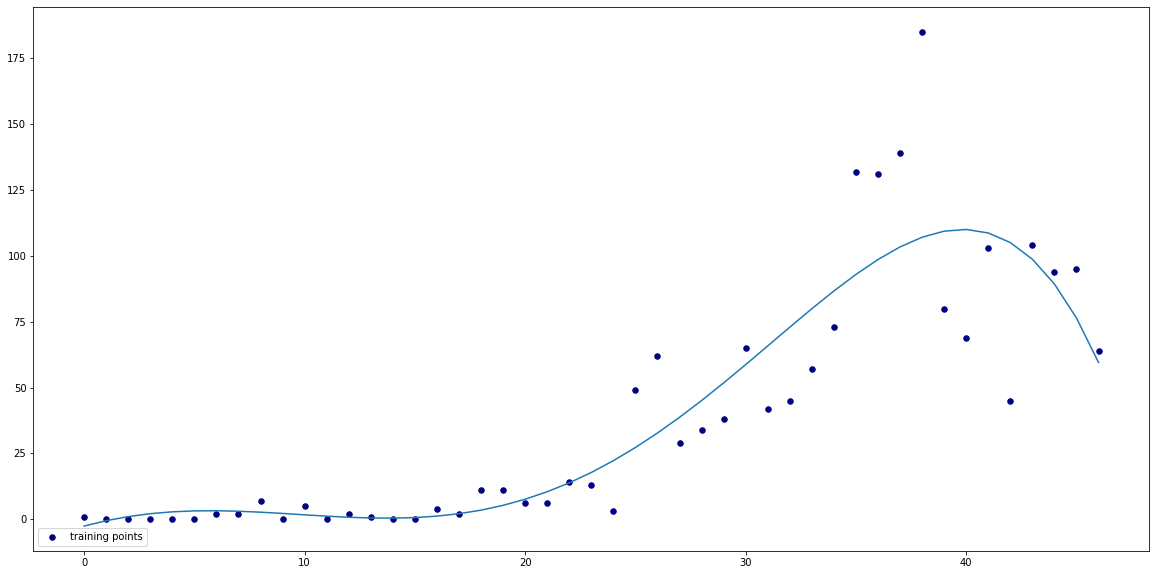

In [59]:
#Doing a visual check just to see what the genreal curve looks like

c = 'Algeria1'

#View a plot of the data
plt.figure(figsize=(20,10))

plt.scatter(forPlot[forPlot['country'] == c]['day'], forPlot[forPlot['country'] == c]['new'], color='navy', s=30, marker='o', label="training points")

X = pd.concat([forPlot[forPlot['country'] == c]['day'], forPlot[forPlot['country'] == c].iloc[:, 4:]], axis = 1)
y = forPlot[forPlot['country'] == c]['new']

interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
#X = interaction.fit_transform(X)

model = make_pipeline(PolynomialFeatures(5), Ridge())
model.fit(X['day'].values.reshape(-1, 1), np.array(y).reshape(-1, 1))
y_plot = model.predict(X['day'].values.reshape(-1, 1))
plt.plot(forPlot[forPlot['country'] == c]['day'], y_plot)

plt.legend(loc='lower left')
print(c)

plt.show()

In [227]:
#Label data based on curve metrics
flatPrior = []
increasing = []
top = []
pastPeak = []

for fP in forPlot['country'].unique():
    md = forPlot[forPlot['new'] > 1].groupby('country').min()['date']
    f = len(forPlot[(forPlot['date'] < md[md.index == fP][0]) & (forPlot['country'] == fP)])
    flatPrior.append(f)
    
    p2P = forPlot[(forPlot.index < forPlot[(forPlot['country'] == fP) & (forPlot['rel2Peak'] == -1)].index[0]) & (forPlot['country'] == fP)]
    i = len(p2P[p2P['date'] >= p2P[p2P['new'] > 1]['date'].min()])
    increasing.append(i)
    
    t = len(forPlot[(forPlot['country'] == fP) & (forPlot['rel2Peak'] >= -1) & (forPlot['rel2Peak'] <= 1)])
    top.append(t)
    
    p = len(forPlot[(forPlot['country'] == fP) & (forPlot['rel2Peak'] > 1)])
    pastPeak.append(p)
    
targets = []
for n in range(105):
    for r in range(flatPrior[n]):
        targets.append([0, 0])
    for up in range(increasing[n]):
        targets.append([1, 1])
    for s in range(top[n]):
        targets.append([0, 1])
    for p in range(pastPeak[n]):
        targets.append([1, 0])
        
forPlot['targets'] = targets

#Add a single digit target for plotting purposes
targets2 = []
for n in range(105):
    for r in range(flatPrior[n]):
        targets2.append(0)
    for up in range(increasing[n]):
        targets2.append(1)
    for s in range(top[n]):
        targets2.append(2)
    for p in range(pastPeak[n]):
        targets2.append(3)
        
forPlot['targets2'] = targets2

In [255]:
#Visual check to make sure labels were applied properly
c = 'Afghanistan0'

#View a plot of the data
fig = px.scatter(forPlot[forPlot['country'] == c], x='day', y='new', color = 'targets2', trendline="lowess")
fig.show()

In [346]:
#new = forPlot['targets'].str.split(" ", n = 1, expand = True) 
#forPlot["incline"]= new[0] 
#forPlot["height"]= new[1]

#Shuffle and split x and y, test and train and scale
forPlot2 = forPlot.sample(frac=1)
n_train = int(len(forPlot)*0.8)

X = pd.concat([forPlot2['day'], forPlot2.iloc[:, 4:6], forPlot2.iloc[:, 8:13]], axis = 1)
y = forPlot2['targets'].reset_index(drop=True)

scalerX = preprocessing.StandardScaler()

X2 = scalerX.fit_transform(X)
y2 = []
for i in range(len(y)):
    y2.append(np.array(y[i]).reshape(-1, 1))
y3 = np.array(y2).reshape(5743, 2)

X_train = X2[:n_train]
X_test = X2[n_train:]
y_train = np.array(y2[:n_train]).reshape(4594, 2)
y_test = np.array(y2[n_train:]).reshape(1149, 2)

In [322]:
#Build model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

#Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit model
model.fit(X_train, y_train, epochs=150, batch_size=10)

Epoch 1/150
4594/4594 [==============================] - 1s 195us/step - loss: 0.5795 - accuracy: 0.7453
Epoch 2/150
4594/4594 [==============================] - 1s 149us/step - loss: 0.4355 - accuracy: 0.8158
Epoch 3/150
4594/4594 [==============================] - 1s 150us/step - loss: 0.4202 - accuracy: 0.8172
Epoch 4/150
4594/4594 [==============================] - 1s 144us/step - loss: 0.4122 - accuracy: 0.8187
Epoch 5/150
4594/4594 [==============================] - 1s 152us/step - loss: 0.4069 - accuracy: 0.8182
Epoch 6/150
4594/4594 [==============================] - 1s 151us/step - loss: 0.3999 - accuracy: 0.8180
Epoch 7/150
4594/4594 [==============================] - 1s 149us/step - loss: 0.3951 - accuracy: 0.8198
Epoch 8/150
4594/4594 [==============================] - 1s 163us/step - loss: 0.3899 - accuracy: 0.8206
Epoch 9/150
4594/4594 [==============================] - 1s 191us/step - loss: 0.3856 - accuracy: 0.8189
Epoch 10/150
4594/4594 [==============================]

4594/4594 [==============================] - 1s 143us/step - loss: 0.2970 - accuracy: 0.8566
Epoch 79/150
4594/4594 [==============================] - 1s 140us/step - loss: 0.2955 - accuracy: 0.8595
Epoch 80/150
4594/4594 [==============================] - 1s 144us/step - loss: 0.2958 - accuracy: 0.8575
Epoch 81/150
4594/4594 [==============================] - 1s 142us/step - loss: 0.2952 - accuracy: 0.8576
Epoch 82/150
4594/4594 [==============================] - 1s 141us/step - loss: 0.2955 - accuracy: 0.8582
Epoch 83/150
4594/4594 [==============================] - 1s 148us/step - loss: 0.2945 - accuracy: 0.8594
Epoch 84/150
4594/4594 [==============================] - 1s 147us/step - loss: 0.2927 - accuracy: 0.8624
Epoch 85/150
4594/4594 [==============================] - 1s 145us/step - loss: 0.2922 - accuracy: 0.8626
Epoch 86/150
4594/4594 [==============================] - 1s 150us/step - loss: 0.2921 - accuracy: 0.8586
Epoch 87/150
4594/4594 [==============================] - 1

In [347]:
#Generate predictions for spot tests
preds = model.predict(X_train)

#Evaluate model on unseen data
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 86.12%
